# SVM Objective
$\min_{w \in \mathbb{R}^p, b \in \mathbb{R}} F(w,b)$ where $F(w,b) := \frac{1}{n} \sum_{i=1}^{n} \max\left \{ 1 - y_i(< w,x_i >+ b), 0 \right \}{}$

## SGD
$\text{let} \space \lambda = \frac{1}{C}$

$\nabla_{w} \tilde{F}(w_k, b_k) = \frac{1}{|B_k|} \sum_{r \in B_k}
\begin{cases}
 -y_rx_r \qquad \text{if} \space y_i < w_k,x_r> +b_k \leq 1  \\ 
 0 \space \qquad\quad\space\space \text{o.w.}
\end{cases} + \lambda w_k$  

$\nabla_{b} \tilde{F}(w_k, b_k) = \frac{1}{|B_k|} \sum_{r \in B_k}
\begin{cases}
 -y_r \qquad \text{if} \space y_i < w_k,x_r> +b_k \leq 1  \\ 
 0 \space \quad\quad\space\space\space \text{o.w.}
\end{cases}$

### Update weight
$w_{k+1} \leftarrow w_k - \eta \nabla_w \tilde{F}(w_k,b_k)$  
$b_{k+1} \leftarrow b_k - \eta \nabla_b \tilde{F}(w_k,b_k)$


# Load data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
random_state = 1124

## Iris dataset

In [0]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True)

## Wine dataset

In [0]:
import pandas as pd

wine_url = '//content/drive/My Drive/2019/2019-2/인공지능/PBL2/data/winequality.csv'

wine = pd.read_csv(wine_url, sep=',', index_col=0)
wine.head()
X = wine.drop(['color'], axis=1).values
y = wine['color'].values

X_train, X_test, y_train, y_test =\
    train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y, shuffle=True)

## MNIST dataset

In [0]:
import struct
import numpy as np
from sklearn.model_selection import train_test_split

fname_img = "/content/drive/My Drive/2019/2019-2/인공지능/PBL2/data/newtrain-images-idx3-ubyte"
fname_lbl = "/content/drive/My Drive/2019/2019-2/인공지능/PBL2/data/newtrain-labels-idx1-ubyte"

with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        y = np.fromfile(flbl, dtype=np.int8)

with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        X = np.fromfile(fimg, dtype=np.uint8).reshape(len(y), -1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=random_state, shuffle=True)

### Scaler

In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

### PCA

In [0]:
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
# pca.explained_variance_ratio_

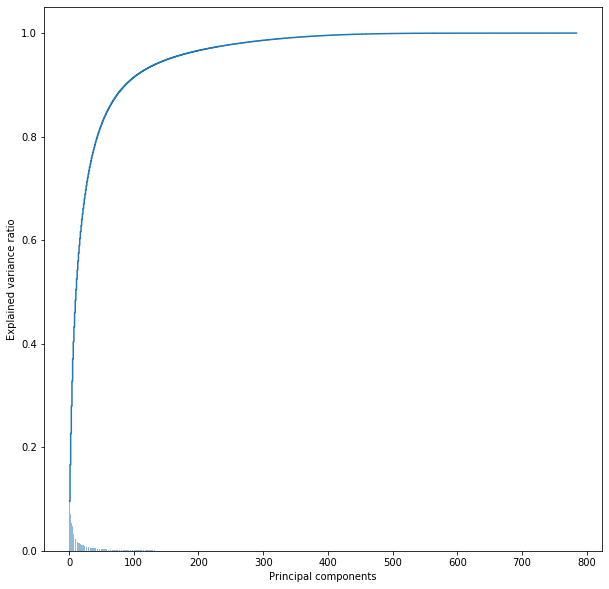

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))

plt.bar(range(1, len(pca.explained_variance_ratio_) +1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.savefig('/content/drive/My Drive/2019/2019-2/인공지능/PBL2/fig/MNIST_PCA.png', dpi=600, bbox_inches='tight')
plt.show()

In [9]:
dd = np.where(np.cumsum(pca.explained_variance_ratio_) < 0.95, 1, 0)
np.sum(dd)

153

In [0]:
pca = PCA(n_components=153)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [0]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_std = sc.fit_transform(X_train_pca)
X_test_std = sc.transform(X_test_pca)

### PCA on std

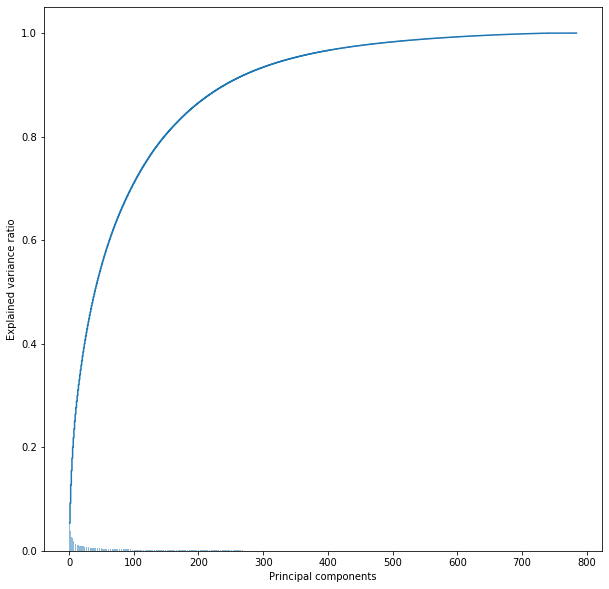

In [135]:
plt.figure(figsize=(10, 10))

plt.bar(range(1, len(pca.explained_variance_ratio_) +1), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, len(pca.explained_variance_ratio_)+1), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.savefig('/content/drive/My Drive/2019/2019-2/인공지능/PBL2/fig/MNIST_PCA.png', dpi=600, bbox_inches='tight')
plt.show()

In [0]:
dd = np.where(np.cumsum(pca.explained_variance_ratio_) < 0.93, 1, 0)
np.sum(dd)

289

In [0]:
pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# SVC class

In [0]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from math import ceil
from sklearn.metrics import accuracy_score

In [0]:
class SVC(BaseEstimator, ClassifierMixin):
    def __init__(self, eta=0.1, max_iter=50, C=0.1,
                 shuffle=True, randome_state=1, batch_size=32,
                 validation_data=None):
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.lambda_ = 1.0 / C
        self.shuffle = shuffle
        self.random_state = random_state
        self.batch_size = batch_size
        self.validation_data = validation_data
        self.history_ = {'train_acc': [], 'valid_acc': []}
    
    def fit(self, X, y):
        self.classes_, y = np.unique(y, return_inverse=True)
        num_class, p = len(self.classes_), X.shape[1]
        self._initialize_weights(num_class, p)

        r = np.arange(X.shape[0])

        for k in range(self.max_iter):
            if self.shuffle:
                self.rgen.shuffle(r)

            for i in range(ceil(X.shape[0] / self.batch_size)):
                batch_r = r[self.batch_size * i : self.batch_size * (i + 1)]
                sum_w = np.zeros((num_class, p))
                sum_b = np.zeros(num_class)

                for idx in batch_r:
                    xi = X[idx]
                    yi = -1 * np.ones(num_class)
                    yi[y[idx]] = 1

                    conf = yi * (np.dot(self.w_, xi) + self.b_)
                    conf_idx = np.where(conf < 1)

                    yt = yi.reshape(yi.shape[0], -1)
                    xt = xi.reshape(-1, xi.shape[0])

                    sum_w[conf_idx] -= np.dot(yt, xt)[conf_idx]
                    sum_b[conf_idx] -= yi[conf_idx]

                # Update
                self.w_ = self.w_ - self.eta *\
                            (sum_w / len(batch_r) + self.lambda_ * self.w_)
                self.b_ = self.b_ - self.eta * sum_b / len(batch_r)

            # Validation score
            self.history_['train_acc'].append(self._score(X, y))
            if self.validation_data is not None:
                X_valid, y_valid = self.validation_data
                self.history_['valid_acc'].append(self._score(X_valid, y_valid))
                
            if k % 10 == 0:
                print(f'Iteration {k + 1} / {self.max_iter} \t', end='')
                print(f"train_acc {self.history_['train_acc'][-1]} \t", end='')
                print(f"valid_acc {self.history_['valid_acc'][-1]} \t", end='')
                print()

        return self

    def _score(self, X, y):
        pred = self.predict(X)
        score = accuracy_score(y, pred)
        return score

    def _initialize_weights(self, n_class, p):
        """
        Initialize weights to small random numbers.
        """
        self.rgen = np.random.RandomState(self.random_state)
        self.w_ = self.rgen.normal(loc=0.0, scale=0.01, size=(n_class, p))
        self.b_ = np.zeros(n_class)

    def predict(self, X):
        dist = np.dot(X, self.w_.T) + self.b_
        pred = np.argmax(dist, axis=1)

        return self.classes_[pred]


In [0]:
train, test = X_train_std, X_test_std
# train, test = X_train_pca, X_test_pca

In [0]:
from datetime import datetime

# classifier class
clf = SVC(max_iter=500, eta=0.001, C=1000, randome_state=random_state, validation_data=(test, y_test), batch_size=256)

start_time = datetime.now()
clf.fit(train, y_train)
end_time = datetime.now()

y_pred = clf.predict(test)

score = accuracy_score(y_pred, y_test)
print('learning time:', end_time - start_time)
print('accuracy:', score)

Iteration 1 / 500 	train_acc 0.795875 	valid_acc 0.7945625 	
Iteration 11 / 500 	train_acc 0.811140625 	valid_acc 0.8093125 	
Iteration 21 / 500 	train_acc 0.851609375 	valid_acc 0.8493125 	
Iteration 31 / 500 	train_acc 0.86734375 	valid_acc 0.8655 	
Iteration 41 / 500 	train_acc 0.875953125 	valid_acc 0.8725625 	


<Figure size 864x864 with 0 Axes>

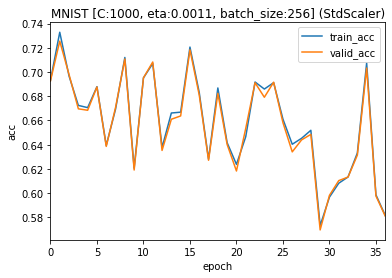

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

title = 'MNIST [C:1000, eta:0.0011, batch_size:256] (StdScaler)'

df = pd.DataFrame(clf.history_)
df.to_csv('/content/drive/My Drive/2019/2019-2/인공지능/PBL2/fig/'+title+'.csv', mode='w')

# df = df.iloc[100:]

plt.figure(figsize=(12, 12))
df.plot()
plt.title(title)
plt.xlabel("epoch")
plt.ylabel("acc")

plt.savefig('/content/drive/My Drive/2019/2019-2/인공지능/PBL2/fig/'+title+'.png', dpi=600, bbox_inches='tight')
plt.show()
